In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [ ]:
#df =pd.read_csv(r'/content/drive/MyDrive/CA683_Assignment/YelpDataset/102442_related/yelp_102442_lang.csv')

In [ ]:
df =pd.read_csv(r'/content/drive/MyDrive/CA683_Assignment/YelpDataset/20210411/20210411_final_data_265062.csv')

In [ ]:
review_df =df

In [ ]:
#Removing Punctuation will help us reduce the size of the training data
review_df['text'] = review_df['text'].str.replace('[^\w\s]','')

In [ ]:
import re
# remove unusual characters
review_df['text']= review_df['text'].apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))

In [ ]:
#To lowercase
review_df['text'] = review_df['text'].str.lower()

In [ ]:
#remove digits
review_df['text'] = review_df['text'].apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))

In [ ]:
len(review_df)

275197

In [ ]:
#df.head()
rev =review_df

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_samp= review_df['text']
y_samp= review_df['stars']

In [ ]:
X_train, X_test, y, y_test = train_test_split(X_samp, y_samp, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((220157,), (55040,))

In [ ]:
rev_samp = rev.sample(n = 275197, random_state = 42)
train = rev_samp[0:220157]
test = rev_samp[220157:]

In [ ]:
train.shape, test.shape

((220157, 12), (55040, 12))

,text,stars
247817,Closed? Bought a Gift Certificate off Restaur...,1.0
222386,Breakfast brunch at the Venetian....Pricey is ...,2.0
96562,I always here good things about Chinese places...,5.0
114737,A must if you love Italian food. Highly recomm...,5.0
130042,Great food and Atmosphere. Location is perfect...,5.0


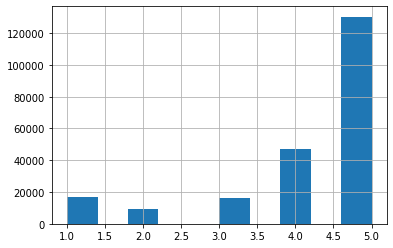

In [ ]:
train = train[['text', 'stars']]
test = test[['text', 'stars']]
train['stars'].hist();train.head()

In [ ]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1.0,stars_2.0,stars_3.0,stars_4.0,stars_5.0
247817,Closed? Bought a Gift Certificate off Restaur...,1,0,0,0,0
222386,Breakfast brunch at the Venetian....Pricey is ...,0,1,0,0,0
96562,I always here good things about Chinese places...,0,0,0,0,1
114737,A must if you love Italian food. Highly recomm...,0,0,0,0,1
130042,Great food and Atmosphere. Location is perfect...,0,0,0,0,1


In [ ]:
#test = pd.read_csv('/home/adam/R/Yelp/dataset/model_test.csv', usecols=['text', 'stars'])
test = pd.get_dummies(test, columns = ['stars'])
train.shape, test.shape

((220157, 6), (55040, 6))

In [ ]:
# set frac = 1. to use the entire sample
train_samp = train.sample(frac = 1, random_state = 42)
test_samp = test.sample(frac = 1, random_state = 42)
train_samp.shape, test_samp.shape

((220157, 6), (55040, 6))

In [ ]:
train_samp.head()

,text,stars_1.0,stars_2.0,stars_3.0,stars_4.0,stars_5.0
238236,Nothing really special. I've tried better. Eve...,1,0,0,0,0
180847,Absolutely sucks. Didn't have enough spicy nug...,1,0,0,0,0
34949,"If you're looking for great Dim Sum, go to Yum...",0,0,0,1,0
47076,Excellent bar food! Tucked away location wort...,0,0,0,0,1
261441,Incredibly cool space with an amazing assortme...,0,0,0,0,1


In [ ]:
#!wget 'http://nlp.stanford.edu/data/glove.6B.zip'
#!unzip '/content/glove.6B.zip'

In [ ]:
#!wget 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
#!unzip '/content/glove.twitter.27B.zip'

--2021-04-06 18:00:04--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-04-06 18:00:04--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-04-06 18:00:04--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
# I'm using GLoVe word vectors to get pretrained word embeddings
embed_size = 200 
# max number of unique words 
#max_features = 40000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = '/content/drive/MyDrive/CA683_Assignment/YelpDataset/102442_related/glove.twitter.27B.200d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [ ]:
#Self-trained word2vec
embed_size = 200 
# max number of unique words 
#max_features = 40000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = '/content/drive/MyDrive/CA683_Assignment/YelpDataset/Data final new/word2vec200_new.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [ ]:
len(embeddings_index)

12159

In [ ]:
class_names = ['stars_1.0',	'stars_2.0',	'stars_3.0',	'stars_4.0',	'stars_5.0']
# Splitting off my y variable
y = train_samp[class_names].values

In [ ]:
y_test =test_samp[class_names].values

In [ ]:
y_test.shape

(55040, 5)

In [ ]:
max_features = 400000

In [ ]:
tokenizer = Tokenizer(num_words=max_features,lower = True)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [ ]:
x_train.shape

(220157, 200)

In [ ]:
word_index = tokenizer.word_index

max_features = 400000 
nb_words = min(max_features, len(word_index)+1)
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [ ]:
len(word_index)

51825

In [ ]:
len(missed)

40051

In [ ]:
missed[0:10]

['the', 'is', 'a', 'was', 'i', 'to', 'for', 'this', 'it', 'of']

In [ ]:
missed[1000:1010]

['degrees',
 'freezing',
 'allows',
 'shells',
 'tunes',
 'peaks',
 'canes',
 'whats',
 'falling',
 'cuisines']

In [ ]:
max_features = 51826 #max_features =len(word_index)+1

In [ ]:
#model to classify 5 star groups
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size , weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(42, return_sequences=True))(x)
x = Bidirectional(GRU(42, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)


model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 200)     10365200    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 84)      81648       spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_data=(x_test, y_test), callbacks=[earlystop, checkpoint])

Epoch 1/20
430/430 [==============================] - 1222s 3s/step - loss: 0.3436 - accuracy: 0.6239 - val_loss: 0.2458 - val_accuracy: 0.7170
Epoch 2/20
430/430 [==============================] - 1212s 3s/step - loss: 0.2495 - accuracy: 0.7094 - val_loss: 0.2385 - val_accuracy: 0.7250
Epoch 3/20
430/430 [==============================] - 1211s 3s/step - loss: 0.2405 - accuracy: 0.7208 - val_loss: 0.2339 - val_accuracy: 0.7317
Epoch 4/20
430/430 [==============================] - 1208s 3s/step - loss: 0.2347 - accuracy: 0.7286 - val_loss: 0.2328 - val_accuracy: 0.7341
Epoch 5/20
430/430 [==============================] - 1204s 3s/step - loss: 0.2292 - accuracy: 0.7358 - val_loss: 0.2296 - val_accuracy: 0.7354
Epoch 6/20
430/430 [==============================] - 1204s 3s/step - loss: 0.2254 - accuracy: 0.7403 - val_loss: 0.2297 - val_accuracy: 0.7371
Epoch 7/20
430/430 [==============================] - 1200s 3s/step - loss: 0.2212 - accuracy: 0.7454 - val_loss: 0.2294 - val_accuracy:

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 200)     10365200    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 84)      81648       spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)

54/54 [==============================] - 82s 1s/step


In [ ]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

54/54 [==============================] - 81s 1s/step - loss: 0.2369 - accuracy: 0.7325


[0.23685389757156372, 0.7325218319892883]

In [ ]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      4169
           1       0.43      0.39      0.41      2396
           2       0.54      0.43      0.48      4070
           3       0.54      0.36      0.43     11646
           4       0.81      0.92      0.86     32759

    accuracy                           0.73     55040
   macro avg       0.61      0.58      0.59     55040
weighted avg       0.71      0.73      0.71     55040



In [ ]:
# Don't actually need to save it for the kernel
model.save('yelp_nn_selfword2vec_42u_model_1.h5')

In [ ]:
from tensorflow import keras
history = keras.models.load_model('/content/drive/MyDrive/yelp_nn_selfword2vec_42u_model_1.h5')

In [ ]:
y_test = history.predict([x_test], batch_size=1024, verbose = 1)

54/54 [==============================] - 82s 1s/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
history.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 200)     10365200    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 84)      81648       spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: ignored